# UMAP

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import *
from pyspark.sql.functions import *
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Demo 1: MNIST dataset

### Load dataset

In [2]:
"""
Load and return OpenML's MNIST database of handwritten digits with 70,000 examples and 784 features across 10 classes.
Loads the data into a pandas DataFrame with default datatype float64.
"""

mnist = fetch_openml("mnist_784", version=1, parser='auto')
print(mnist.data.shape)
mnist.data.info(memory_usage='deep')

(70000, 784)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 418.7 MB


## Convert dataset to Spark DataFrame

#### Create Spark Session
UMAP is a driver-intensive algorithm. Be sure to allocate enough resources for the driver in the Spark config.

In [3]:
num_threads = 6
driver_memory = "15g"

_config = {
    "spark.master": f"local[{num_threads}]",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    # allocate enough driver memory and set maxResultSize to 0 to avoid serialization limits
    "spark.driver.memory": driver_memory,
    "spark.driver.maxResultSize": "0",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
}
spark = SparkSession.builder.appName("spark-rapids-ml umap")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

23/08/10 12:24:38 WARN Utils: Your hostname, 728fbda-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.44.254 instead (on interface enp1s0)
23/08/10 12:24:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/10 12:24:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Convert dataset to Spark DataFrame

In [4]:
mnist_df = spark.createDataFrame(mnist.data)
mnist_df.cache().show(5)

23/08/10 12:24:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/08/10 12:24:43 WARN TaskSetManager: Stage 0 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.


70000

## Spark RAPIDS ML (GPU)

In [2]:
from spark_rapids_ml.umap import UMAP

In [6]:
feature_cols = [f"pixel{i}" for i in range(1, mnist.data.shape[1] + 1)]
umap_estimator = UMAP(num_workers=6).setFeaturesCols(feature_cols)

### Fit
Note that fit is executed on a single node, as multi-node fitting is not yet supported.

In [7]:
start_time = time.time()
umap_model = umap_estimator.fit(mnist_df)
print(f"Fit took: {time.time() - start_time} sec")

23/08/10 12:24:54 WARN TaskSetManager: Stage 3 contains a task of very large size (429015 KiB). The maximum recommended task size is 1000 KiB.
2023-08-10 12:24:57,092 - spark_rapids_ml.umap.UMAP - INFO - Initializing cuml context
2023-08-10 12:24:58,611 - spark_rapids_ml.umap.UMAP - INFO - Loading data into python worker memory
2023-08-10 12:25:01,715 - spark_rapids_ml.umap.UMAP - INFO - Cuml fit complete


Fit took: 18.37415075302124 sec


#### Saving and loading
The UMAP estimator and model can be persisted using the PySpark save() API. Below is an example of saving and loading the model after fitting. The trained embeddings are retained. 

In [8]:
model_path = "/tmp/umap-model"
umap_model.write().overwrite().save(model_path)
umap_model_loaded = umap_model.load(model_path)
print("Model embedding shape:", len(umap_model_loaded.embedding), ",", len(umap_model_loaded.embedding[0]))

Model embedding shape: 70000 , 2


### Transform

In [9]:
start_time = time.time()
df_output = umap_model.transform(mnist_df)
df_output.cache()
df_output.count()
print(f"Transform took: {time.time() - start_time} sec")

23/08/10 12:25:10 WARN TaskSetManager: Stage 8 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.


Transform took: 24.40177845954895 sec


#### Visualize embedding
Notice that UMAP groups individual digit classes while retaining the global structure among different digit classes. 
Groups of digits that may blend together, such as (4, 9) and (3, 5, 8) are embedded near each other, while distinct digits such as (0, 1) are placed far from each other.

23/08/10 12:25:35 WARN TaskSetManager: Stage 11 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.


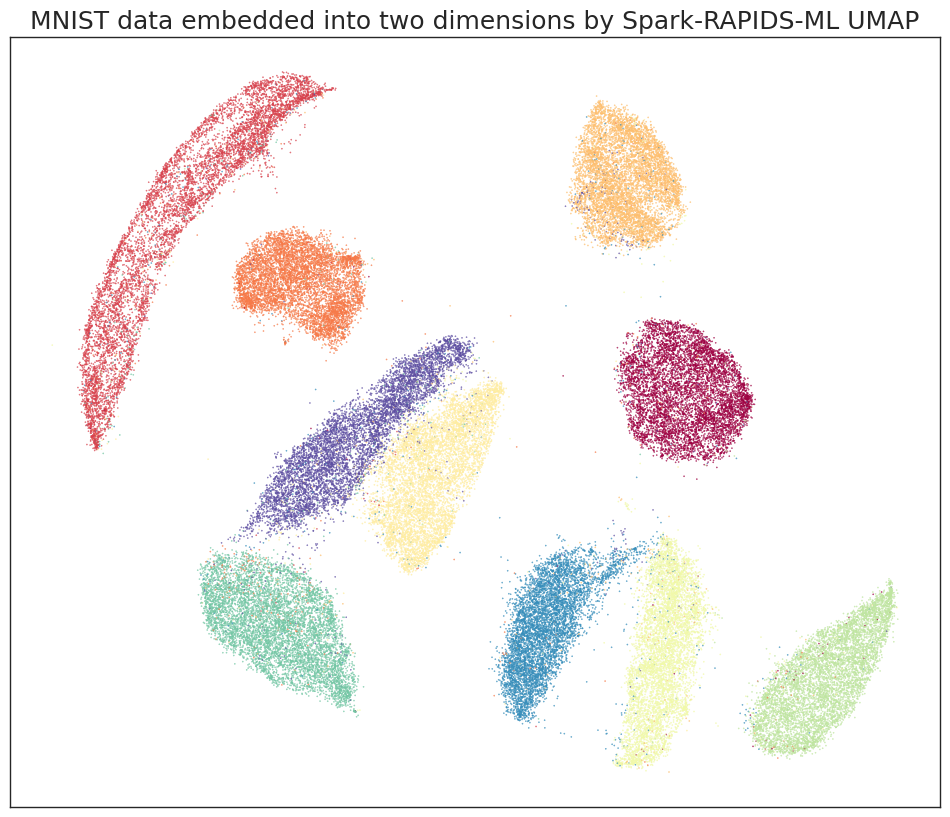

/tmp/ipykernel_1422393/4225546272.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Spectral", 10)


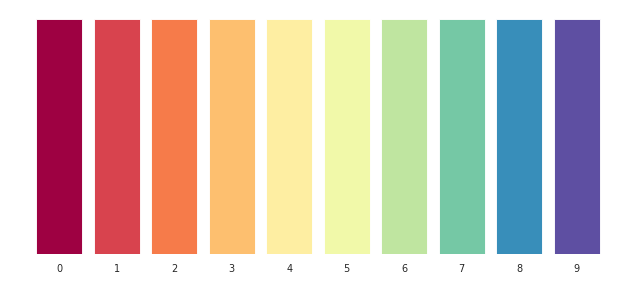

In [10]:
pd_output = df_output.toPandas()
embedding = np.array(pd_output["embedding"].to_list())

# Plot the transformed embeddings
sns.set(context="paper", style="white")
fig, ax = plt.subplots(figsize=(12, 10))
color = mnist.target.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by Spark-RAPIDS-ML UMAP", fontsize=18)
plt.show()

# Plot the digit colors
cmap = plt.cm.get_cmap("Spectral", 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        dpi=80, facecolor='w', edgecolor='k')
for sp in ax.spines.values():
    sp.set_visible(False)
bars = ax.bar(np.arange(10), [1]*10, color=[cmap(i/9) for i in range(10)])
plt.xticks(np.arange(10), np.arange(10))
ax.set_yticks([])
plt.show()

## UMAP (Local, CPU)

In [11]:
%pip install umap-learn
import umap as local_umap

Note: you may need to restart the kernel to use updated packages.


/home/rishic/anaconda3/envs/rapids-23.06/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rishic/anaconda3/envs/rapids-23.06/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rishic/anaconda3/envs/rapids-23.06/lib/python3.9/site-

In [12]:
local_umap = local_umap.UMAP()

### Fit

In [13]:
start_time = time.time()
local_umap.fit(mnist.data)
print(f"Fit took: {time.time() - start_time} sec")

Fit took: 44.39983916282654 sec


### Transform

In [14]:
start_time = time.time()
embedding = local_umap.transform(mnist.data)
print(f"Transform took: {time.time() - start_time} sec")

Transform took: 0.3944551944732666 sec


### Visualize embedding

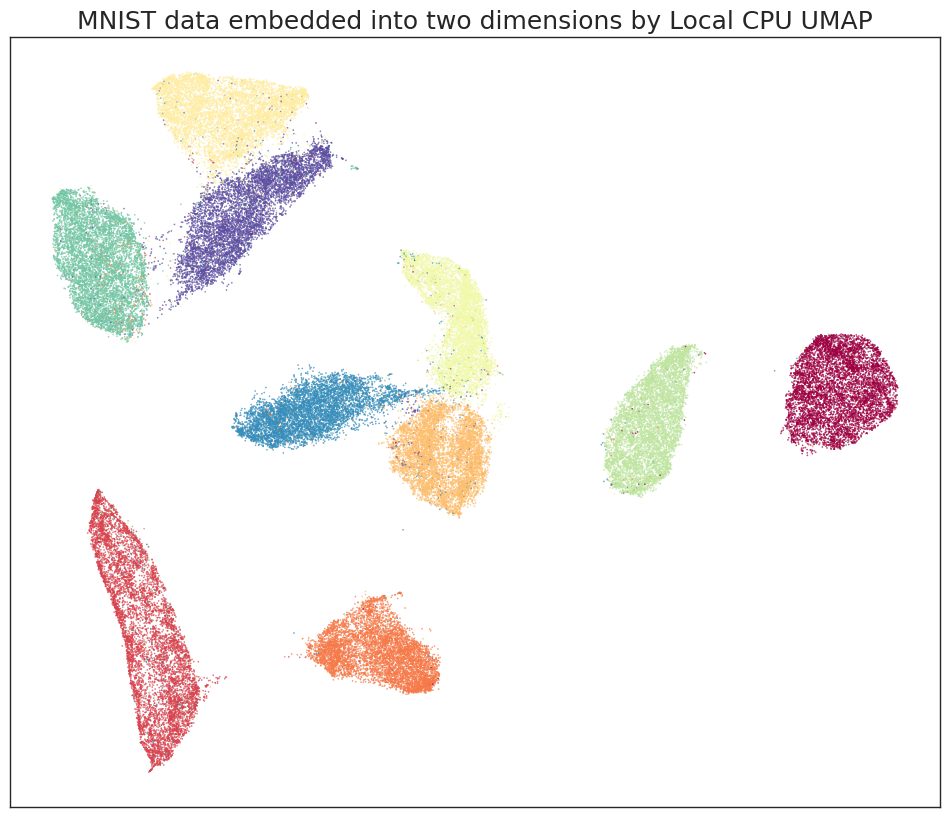

/tmp/ipykernel_1422393/1413413876.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Spectral", 10)


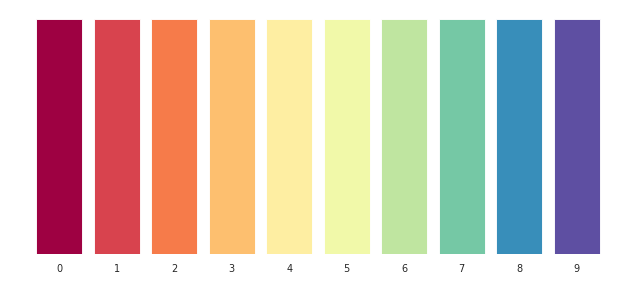

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
color = mnist.target.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by Local CPU UMAP", fontsize=18)
plt.show()

# Plot the digit colors
cmap = plt.cm.get_cmap("Spectral", 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        dpi=80, facecolor='w', edgecolor='k')
for sp in ax.spines.values():
    sp.set_visible(False)
bars = ax.bar(np.arange(10), [1]*10, color=[cmap(i/9) for i in range(10)])
plt.xticks(np.arange(10), np.arange(10))
ax.set_yticks([])
plt.show()

## Demo 2: Large blobs dataset

### Load dataset
Below is an example of UMAP on a much larger synthetic clustering dataset.  
Be sure your local machine has enough memory to handle the resultant model and embeddings. Adjust --num_rows and --num_cols accordingly.   
By default, blobs creates a 3-class dataset.

In [3]:
!python ../python/benchmark/gen_data_distributed.py blobs --num_rows 100000 --num_cols 3000 --dtype float32 --output_dir "./blobs_100k_3k_f32.parquet" --feature_type array --overwrite --output_num_files 20 --spark_confs spark.driver.memory=20g --spark_confs spark.master=local[16]

23/08/10 12:26:55 WARN Utils: Your hostname, 728fbda-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.44.254 instead (on interface enp1s0)
23/08/10 12:26:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/10 12:26:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Passing {'random_state': 1} to make_blobs
23/08/10 12:27:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
root                                                                            
 |-- feature_array: array (nullable = false)
 |    |-- element: float (containsNull = true)

gen_data finished
stopping spark session


### Download Spark RAPIDS Plugin
The Spark RAPIDS Plugin is included in the Spark config for accelerated and multi-threaded file reading.  

In [4]:
import os
import requests

SPARK_RAPIDS_VERSION = "23.06.0"
cuda_version = "12"
rapids_jar = f"rapids-4-spark_2.12-{SPARK_RAPIDS_VERSION}.jar"

if not os.path.exists(rapids_jar):
    print("Downloading spark rapids jar")
    url = f"https://repo1.maven.org/maven2/com/nvidia/rapids-4-spark_2.12/{SPARK_RAPIDS_VERSION}/rapids-4-spark_2.12-{SPARK_RAPIDS_VERSION}-cuda{cuda_version}.jar"
    response = requests.get(url)
    if response.status_code == 200:
        with open(rapids_jar, "wb") as f:
            f.write(response.content)
        print(f"File '{rapids_jar}' downloaded and saved successfully.")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


#### Create Spark Session

In [5]:
num_threads = 6
driver_memory = "20g"
num_gpus = 1

_config = {
    "spark.master": f"local[{num_threads}]",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    "spark.driver.memory": driver_memory,
    "spark.driver.maxResultSize": "0",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
    "spark.rapids.ml.uvm.enabled": "true",
    # accelerated file/parquet reading
    "spark.jars": rapids_jar,
    "spark.executorEnv.PYTHONPATH": rapids_jar,
    "spark.sql.files.minPartitionNum": num_gpus,
    "spark.rapids.memory.gpu.minAllocFraction": "0.0001",
    "spark.plugins": "com.nvidia.spark.SQLPlugin",
    "spark.locality.wait": "0s",
    "spark.sql.cache.serializer": "com.nvidia.spark.ParquetCachedBatchSerializer",
    "spark.rapids.memory.gpu.pooling.enabled": "false",
    "spark.rapids.sql.explain": "ALL",
    "spark.sql.execution.sortBeforeRepartition": "false",
    "spark.rapids.sql.format.parquet.reader.type": "MULTITHREADED",
    "spark.rapids.sql.format.parquet.multiThreadedRead.maxNumFilesParallel": "20",
    "spark.rapids.sql.multiThreadedRead.numThreads": "20",
    "spark.rapids.sql.python.gpu.enabled": "true",
    "spark.rapids.memory.pinnedPool.size": "2G",
    "spark.python.daemon.module": "rapids.daemon",
    "spark.rapids.sql.batchSizeBytes": "512m",
    "spark.sql.adaptive.enabled": "false",
    "spark.sql.files.maxPartitionBytes": "2000000000000",
    "spark.rapids.sql.concurrentGpuTasks": "2",
    "spark.sql.execution.arrow.maxRecordsPerBatch": "20000",
}
spark = SparkSession.builder.appName("spark-rapids-ml umap")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

23/08/10 12:27:30 WARN Utils: Your hostname, 728fbda-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.44.254 instead (on interface enp1s0)
23/08/10 12:27:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/08/10 12:27:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/10 12:27:31 WARN RapidsPluginUtils: RAPIDS Accelerator 23.06.0 using cudf 23.06.0.
23/08/10 12:27:32 WARN RapidsPluginUtils: RAPIDS Accelerator is enabled, to disable GPU support set `spark.rapids.sql.enabled` to false.
23/08/10 12:27:32 WARN RapidsPluginUtils: spark.rapids.sql.explain is set to `ALL`. Set it to 'NONE' to suppress the diagnostics logging about the query placement on the GPU.
23/08/10 12:27:36 WARN GpuDeviceManager: RMM pool is disabled since spark.rapids.memor

### Create estimator

In [6]:
blobs_df = spark.read.parquet("blobs_100k_3k_f32.parquet")
features_cols = [f"c{i}" for i in range(3000)]
umap_estimator = UMAP(num_workers=6).setFeaturesCol("feature_array")

In [7]:
blobs_df.cache()
blobs_df.show()

23/08/10 12:27:43 WARN GpuOverrides: 
*Exec <FileSourceScanExec> will run on GPU

23/08/10 12:27:43 WARN GpuOverrides: 
!Exec <CollectLimitExec> cannot run on GPU because the Exec CollectLimitExec has been disabled, and is disabled by default because Collect Limit replacement can be slower on the GPU, if huge number of rows in a batch it could help by limiting the number of rows transferred from GPU to CPU. Set spark.rapids.sql.exec.CollectLimitExec to true if you wish to enable it
  @Partitioning <SinglePartition$> could run on GPU
  *Exec <ProjectExec> will run on GPU
    *Expression <Alias> cast(feature_array#0 as string) AS feature_array#8 will run on GPU
      *Expression <Cast> cast(feature_array#0 as string) will run on GPU
    *Exec <InMemoryTableScanExec> will run on GPU



+--------------------+
|       feature_array|
+--------------------+
|[2.807123423, 7.7...|
|[4.417996883, -8....|
|[1.615787625, 9.5...|
|[-0.769998789, 2....|
|[-3.753956795, 4....|
|[4.476817608, -9....|
|[-1.001603842, 5....|
|[-2.922882318, 3....|
|[5.117163181, -9....|
|[-3.001909494, 3....|
|[-1.952394128, 4....|
|[-0.909557581, 5....|
|[2.58362627, 7.96...|
|[-2.915932417, 4....|
|[5.937945843, -10...|
|[-1.250668526, 4....|
|[6.151247501, -10...|
|[2.70101285, 6.54...|
|[2.971755743, 9.3...|
|[5.599734783, -9....|
+--------------------+
only showing top 20 rows



### Fit

In [8]:
start_time = time.time()
umap_model = umap_estimator.fit(blobs_df)
print(f"Fit took: {time.time() - start_time} sec")

23/08/10 12:27:54 WARN GpuOverrides: 
*Exec <InMemoryTableScanExec> will run on GPU

23/08/10 12:27:54 WARN GpuOverrides: 
!Exec <CollectLimitExec> cannot run on GPU because the Exec CollectLimitExec has been disabled, and is disabled by default because Collect Limit replacement can be slower on the GPU, if huge number of rows in a batch it could help by limiting the number of rows transferred from GPU to CPU. Set spark.rapids.sql.exec.CollectLimitExec to true if you wish to enable it
  @Partitioning <SinglePartition$> could run on GPU
  *Exec <InMemoryTableScanExec> will run on GPU

2023-08-10 12:27:55,010 - spark_rapids_ml.umap.UMAP - INFO - CUDA managed memory enabled.
23/08/10 12:27:55 WARN GpuOverrides: 
*Exec <ProjectExec> will run on GPU
  *Expression <Alias> embedding_#61 AS col_0#65 will run on GPU
  *Expression <Alias> raw_data_#62 AS col_1#66 will run on GPU
  *Exec <MapInPandasExec> will partially run on GPU
    *Expression <PythonUDF> _train_udf(cuml_values#43)#60 will not

Fit took: 49.94405817985535 sec


### Transform

In [9]:
start_time = time.time()
df_output = umap_model.transform(blobs_df)
df_output.cache()
df_output.count()
print(f"Transform took: {time.time() - start_time} sec")

23/08/10 12:28:44 WARN GpuOverrides: 
*Exec <MapInPandasExec> will partially run on GPU
  *Expression <PythonUDF> _transform_udf(feature_array#0)#84 will not block GPU acceleration
  *Exec <InMemoryTableScanExec> will run on GPU

23/08/10 12:28:44 WARN GpuOverrides: 
*Exec <HashAggregateExec> will run on GPU
  *Expression <AggregateExpression> count(1) will run on GPU
    *Expression <Count> count(1) will run on GPU
  *Expression <Alias> count(1)#116L AS count#117L will run on GPU
  *Exec <ShuffleExchangeExec> will run on GPU
    *Partitioning <SinglePartition$> will run on GPU
    *Exec <HashAggregateExec> will run on GPU
      *Expression <AggregateExpression> partial_count(1) will run on GPU
        *Expression <Count> count(1) will run on GPU
      *Exec <InMemoryTableScanExec> will run on GPU



Transform took: 22.231855630874634 sec


### Visualize embedding
Note that the 100,000 samples with 3000 features were mapped into 3 distinct clusters in 2 dimensions.

23/08/10 12:29:20 WARN GpuOverrides: 
*Exec <ProjectExec> will run on GPU
  *Expression <Alias> features#85 AS col_0#166 will run on GPU
  *Expression <Alias> embedding#86 AS col_1#167 will run on GPU
  *Exec <InMemoryTableScanExec> will run on GPU



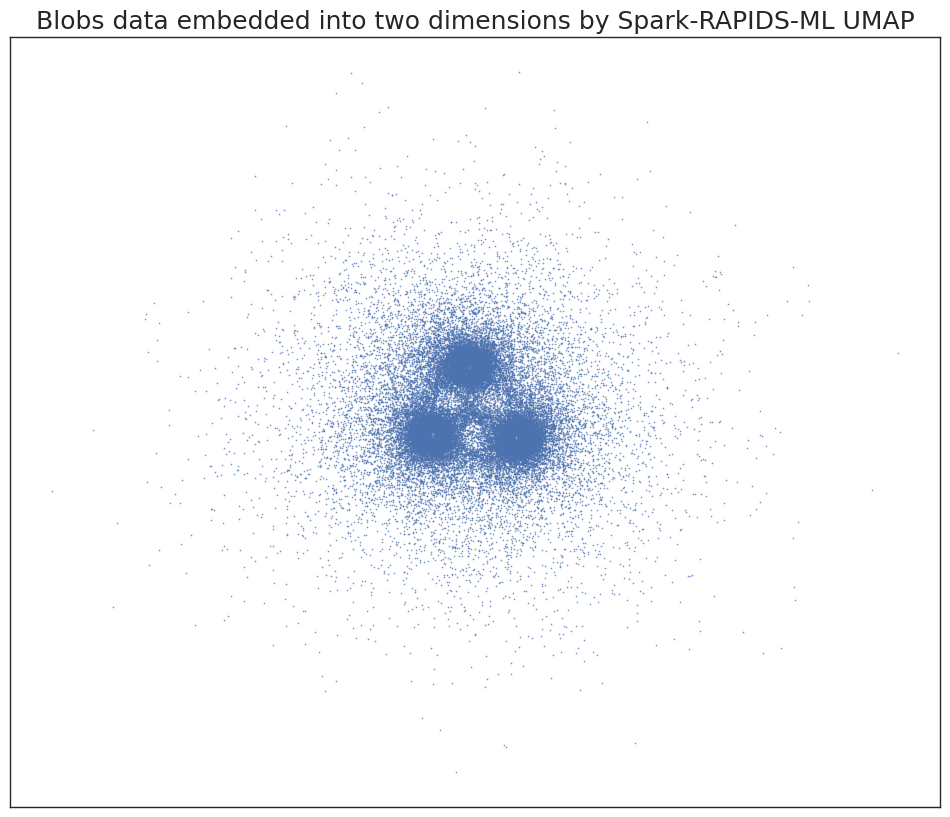

/tmp/ipykernel_1425196/1954154052.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Spectral", 10)


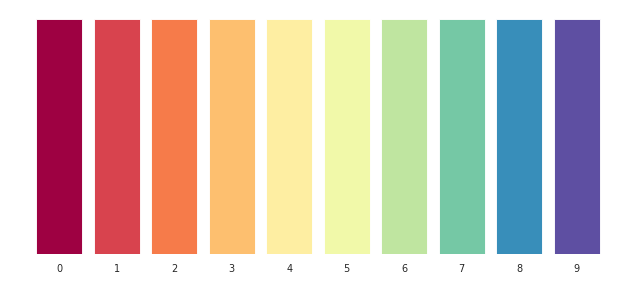

In [10]:
pd_output = df_output.toPandas()
embedding = np.array(pd_output["embedding"].to_list())

# Plot the transformed embeddings
sns.set(context="paper", style="white")
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Blobs data embedded into two dimensions by Spark-RAPIDS-ML UMAP", fontsize=18)
plt.show()

# Plot the digit colors
cmap = plt.cm.get_cmap("Spectral", 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        dpi=80, facecolor='w', edgecolor='k')
for sp in ax.spines.values():
    sp.set_visible(False)
bars = ax.bar(np.arange(10), [1]*10, color=[cmap(i/9) for i in range(10)])
plt.xticks(np.arange(10), np.arange(10))
ax.set_yticks([])
plt.show()